In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import math
from pprint import pprint
from collections import Counter
import gensim


from sklearn.utils.class_weight import compute_class_weight

tqdm.pandas()

In [3]:
data = pd.read_csv('data_m.csv')

In [8]:
# data_0 = data[data['VAP'] == 0]
# data_1 = data[data['VAP'] == 1]

# # Count word frequencies in each class
# counter_0 = Counter(word for text in data_0['TEXT'] for word in text.split())
# counter_1 = Counter(word for text in data_1['TEXT'] for word in text.split())

# # Find words that are common to both classes
# common_words = set(counter_0.keys()).intersection(counter_1.keys())

# # Set the threshold for word removal
# threshold = 0.2

# # Determine words to remove based on their frequency ratio
# words_to_remove = {
#     word for word in common_words
#     if 1 - threshold <= (counter_1[word] / data_1.shape[0]) / (counter_0[word] / data_0.shape[0]) <= 1 + threshold
# }

# # Function to remove selected words
# def remove_selected_words(text):
#     return ' '.join(word for word in text.split() if word not in words_to_remove)

# # Apply the function to the 'TEXT' column
# data['TEXT'] = data['TEXT'].progress_apply(remove_selected_words)

In [4]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

data['TEXT'] = data['TEXT'].progress_apply(clean_text)

  0%|          | 0/3558 [00:00<?, ?it/s]

100%|██████████| 3558/3558 [02:13<00:00, 26.56it/s] 


In [5]:
# remove rows with empty text
data = data[data['TEXT'] != '']

# reindex the DataFrame
data = data.reset_index(drop=True)

<Axes: ylabel='VAP'>

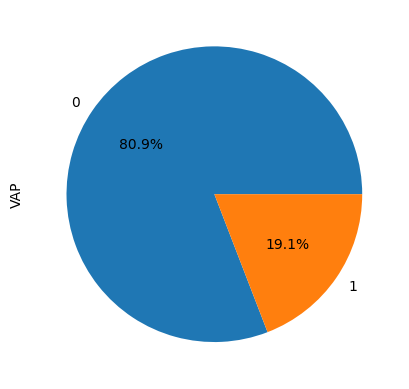

In [6]:
# # create a new dataframe that contains as much data from each class as the number of rows in the class with the least rows
# data_balanced = pd.concat([data[data['VAP'] == 0].sample(data[data['VAP'] == 1].shape[0], random_state=42), data[data['VAP'] == 1]])
# data = data_balanced
# pie chart of Label
data['VAP'].value_counts().plot.pie(autopct='%1.1f%%')

In [7]:
# Load the embedding model
embedding_model = gensim.models.KeyedVectors.load_word2vec_format("bio.bin", binary=True)

# Create a set of words present in the embedding model for faster lookup
words_in_model = set(embedding_model.key_to_index)

# Function to calculate the average number of words per text
def average_words(text_series):
    return text_series.str.split().apply(lambda words: len([word for word in words if word in words_in_model])).mean()

# Calculate averages
average_words_per_text = average_words(data['TEXT'])
print(f'Average words per text: {average_words_per_text}')

average_words_per_text_class_0 = average_words(data[data['VAP'] == 0]['TEXT'])
print(f'Average words per text class 0: {average_words_per_text_class_0}')

average_words_per_text_class_1 = average_words(data[data['VAP'] == 1]['TEXT'])
print(f'Average words per text class 1: {average_words_per_text_class_1}')

Average words per text: 29469.225126475547
Average words per text class 0: 36041.141119221415
Average words per text class 1: 1705.051395007342


In [8]:
chunk_size = 32
max_chunks = 768

In [9]:
# creating a matrix of word embeddings using the cleaned data and the BioWordVec model
embedding_model = gensim.models.KeyedVectors.load_word2vec_format("bio.bin", binary=True)
embed_dim = embedding_model.vector_size

def split_into_chunks(text, chunk_size=200):
    words = text.split()
    return [' '.join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]

def average_embeddings_for_chunk(chunk, embedding_model):
    embeddings = []
    for word in chunk.split():
        try:
            embeddings.append(embedding_model[word])
        except KeyError:
            pass
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_model.vector_size)  # Return zero vector if no words found

def process_text(text, embedding_model, chunk_size=200, max_chunks=256):
    chunks = split_into_chunks(text, chunk_size)
    chunk_embeddings = [average_embeddings_for_chunk(chunk, embedding_model) for chunk in chunks[:max_chunks]]
    # Pad with zeros if there are fewer chunks than max_chunks
    while len(chunk_embeddings) < max_chunks:
        chunk_embeddings.append(np.zeros(embedding_model.vector_size))
    return chunk_embeddings

# Apply the processing to each row in the DataFrame
chunks_of_embeddings = data['TEXT'].progress_apply(lambda text: process_text(text, embedding_model, chunk_size, max_chunks))

100%|██████████| 3558/3558 [02:35<00:00, 22.86it/s] 


In [10]:
# Separate the data by class
class_0 = chunks_of_embeddings[data['VAP'] == 0]
class_1 = chunks_of_embeddings[data['VAP'] == 1]

# Determine the number of samples per class for the training set (15% of total data for each class)
n_samples = int(0.10 * len(chunks_of_embeddings))

# Sample from each class
train_0 = class_0.sample(n=n_samples, random_state=42)
train_1 = class_1.sample(n=n_samples, random_state=42)

# Combine to form the training set
X_train = pd.concat([train_0, train_1])
y_train = data['VAP'].loc[X_train.index]

# Remove the training data from the dataset
remaining_data = chunks_of_embeddings.drop(X_train.index)
remaining_target = data['VAP'].drop(X_train.index)

# Split the remaining data into validation and test sets (50-50 split)
X_val, X_test, y_val, y_test = train_test_split(remaining_data, remaining_target, test_size=0.95, random_state=42, stratify=remaining_target)

In [11]:
print(f'Number of training samples: {len(X_train)}')
print(f'Number of validation samples: {len(X_val)}')
print(f'Number of test samples: {len(X_test)}')

Number of training samples: 710
Number of validation samples: 142
Number of test samples: 2706


In [12]:
# Function to convert embeddings and labels to tensors
def embeddings_to_tensor(embeddings):
    return torch.tensor(embeddings, dtype=torch.float32)

# Convert embeddings and labels to tensors
X_train_tensor = embeddings_to_tensor(X_train.to_list())
X_val_tensor = embeddings_to_tensor(X_val.to_list())
X_test_tensor = embeddings_to_tensor(X_test.to_list())

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [13]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [20]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.5):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, inputs):
        # Permute to [sequence_length, batch_size, hidden_size]
        inputs_perm = inputs.permute(1, 0, 2)
        attn_output, _ = self.att(inputs_perm, inputs_perm, inputs_perm)
        # Back to [batch_size, sequence_length, hidden_size]
        attn_output = attn_output.permute(1, 0, 2)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TextClassificationModel(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, max_seq_len, dropout=0.7, num_transformer_blocks=2):
        super(TextClassificationModel, self).__init__()
        
        # Creating multiple Transformer Blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim)
            for _ in range(num_transformer_blocks)
        ])
        
        # Pooling Layer
        self.pooling = nn.AdaptiveAvgPool1d(1)

        # Additional Linear, BatchNorm, and Dropout Layers
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.batch_norm = nn.BatchNorm1d(embed_dim // 2)
        self.dropout = nn.Dropout(dropout)

        # Final Fully Connected Layer for Classification
        self.fc2 = nn.Linear(embed_dim // 2, 1)
        
        # Positional Encoding Layer
        self.positional_encoding = self.create_positional_encoding(max_seq_len, embed_dim)
    
    
    def forward(self, x):
        seq_len = x.size(1)

        # Get the positional encoding for the sequence length
        scaled_pos_encoding = self.positional_encoding[:seq_len, :]
        scaled_pos_encoding = scaled_pos_encoding.to(x.device)
        scaled_pos_encoding = scaled_pos_encoding.unsqueeze(0).expand(x.size(0), -1, -1)

        # Adding positional encoding
        x = x + scaled_pos_encoding

        # Passing input through each Transformer block sequentially
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        
        # Pooling
        x = x.permute(0, 2, 1)  
        x = self.pooling(x).squeeze(-1)
        
        # Passing through the first linear layer, batch norm, and dropout
        x = F.relu(self.fc1(x))
        x = self.batch_norm(x)
        x = self.dropout(x)

        # Final Classification
        x = self.fc2(x)
        return x

    def create_positional_encoding(self, max_seq_len, embed_dim):
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        positional_encoding = torch.zeros(max_seq_len, embed_dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding

In [14]:
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Calculate class weights
# class_weight = compute_class_weight('balanced', classes=[0, 1], y=y_train)
# class_weight_ratio = class_weight[1] / class_weight[0]
# class_weights_tensor = torch.tensor(class_weight_ratio, dtype=torch.float32, device=device)

# Update the loss function to include class weights
criterion = nn.BCEWithLogitsLoss()

max_seq_len = max_chunks
epochs = 25

In [ ]:
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# import json

# # Define a global variable for the log file
# log_file_path = "hyperopt_log.txt"

# # Define the objective function
# def objective(params):
#     with open(log_file_path, "a") as log_file:
#         log_file.write(f"Trial params: {json.dumps(params)}\n")
    
#     model = TextClassificationModel(
#         embed_dim,
#         int(params['num_heads']),
#         int(params['ff_dim']),
#         max_seq_len,
#         params['dropout'],
#         int(params['num_transformer_blocks'])
#     ).to(device)

#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

#     for epoch in range(epochs):
#         model.train()
#         total_train_loss = 0

#         for X_batch, y_batch in train_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)

#             optimizer.zero_grad()
#             y_pred = model(X_batch).squeeze()
#             loss = criterion(y_pred, y_batch.float())
#             loss.backward()
#             optimizer.step()
#             total_train_loss += loss.item()

#         model.eval()
#         total_val_loss = 0
#         total_val_accuracy = 0
#         total_val_f1 = 0

#         with torch.no_grad():
#             for X_batch, y_batch in val_loader:
#                 X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#                 y_pred = model(X_batch).squeeze()
#                 loss = criterion(y_pred, y_batch.float())
#                 total_val_loss += loss.item()

#                 y_pred = torch.sigmoid(y_pred)
#                 y_pred = torch.round(y_pred)
#                 total_val_accuracy += accuracy_score(y_batch.tolist(), y_pred.tolist())
#                 total_val_f1 += f1_score(y_batch.tolist(), y_pred.tolist())

#         avg_val_loss = total_val_loss / len(val_loader)
#         avg_val_accuracy = total_val_accuracy / len(val_loader)
#         avg_val_f1 = total_val_f1 / len(val_loader)
        
#     with open(log_file_path, "a") as log_file:
#         log_file.write(f"Loss: {avg_val_loss}, Accuracy: {avg_val_accuracy}, F1: {avg_val_f1}\n")
    
#     return {'loss': avg_val_loss, 'status': STATUS_OK}

# # Define the hyperparameter space
# space = {
#     'num_heads': hp.choice('num_heads', [2, 4, 8]),
#     'ff_dim': hp.uniform('ff_dim', 8, 128),
#     'dropout': hp.uniform('dropout', 0.1, 0.9),
#     'learning_rate': hp.loguniform('learning_rate', -7, -2),
#     'weight_decay': hp.loguniform('weight_decay', -7, -2),
#     'num_transformer_blocks': hp.choice('num_transformer_blocks', [1, 2, 3])
# }

# # Run the optimization
# trials = Trials()
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# print("Best Hyperparameters:", best)

100%|██████████| 100/100 [1:19:01<00:00, 47.41s/trial, best loss: 0.010407200627378188]
Best Hyperparameters: {'dropout': 0.46094376887162336, 'ff_dim': 56.00981762367017, 'learning_rate': 0.01837600770292798, 'num_heads': 2, 'num_transformer_blocks': 0, 'weight_decay': 0.0021571100802206134}


In [16]:
num_heads = 8
ff_dim = 80
max_seq_len = max_chunks
dropout = 0.29
num_transformer_blocks = 2
learning_rate = 0.0009
weight_decay = 0.002

# num_heads_choices = [2, 4, 8]
# num_transformer_blocks_choices = [1, 2, 3]


# num_heads = num_heads_choices[best['num_heads']]
# num_transformer_blocks = num_transformer_blocks_choices[best['num_transformer_blocks']]

# ff_dim = int(best['ff_dim'])
# dropout = round(best['dropout'], 2)
# learning_rate = best['learning_rate']
# weight_decay = best['weight_decay']

# Create the model with the correct hyperparameters
#model = TextClassificationModel(embed_dim, num_heads, ff_dim, max_seq_len, dropout, num_transformer_blocks)
#model = model.to(device)

# Define the optimizer
#optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)


#model

In [23]:
print("Using device:", device)

for epoch in range(epochs):
    
    print('-' * 10)
    
    total_train_loss = 0
    total_train_accuracy = 0
    total_train_f1 = 0
    
    model.train()

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    for i, batch in progress_bar:
        progress_bar.set_description(f'[Training] Epoch {epoch}]')
        
        optimizer.zero_grad()
        
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred = model(X_batch).squeeze() 
        
        loss = criterion(y_pred, y_batch.float())
        
        loss.backward()
        optimizer.step()
        
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)

        total_train_loss += loss.item()
        total_train_accuracy += accuracy_score(y_batch.tolist(), y_pred.detach().cpu().numpy().tolist())
        total_train_f1 += f1_score(y_batch.tolist(), y_pred.detach().cpu().numpy().tolist(), average='weighted')
        
        progress_bar.set_postfix({'training_loss': total_train_loss / (i + 1), 'training_accuracy': total_train_accuracy / (i + 1), 'training_f1': total_train_f1 / (i + 1)})
        
    total_val_loss = 0
    total_val_accuracy = 0
    total_val_f1 = 0

    model.eval()
    
    progress_bar = tqdm(enumerate(val_loader), total=len(val_loader))
    
    for i, batch in progress_bar:
        progress_bar.set_description(f'[Validation] Epoch {epoch}]')
        
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        with torch.no_grad():
            y_pred = model(X_batch).squeeze() 
        
        loss = criterion(y_pred, y_batch.float())
        
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        
        total_val_loss += loss.item()
        total_val_accuracy += accuracy_score(y_batch.tolist(), y_pred.tolist())
        total_val_f1 += f1_score(y_batch.tolist(), y_pred.tolist(), average='weighted')
        
        progress_bar.set_postfix({'validation_loss': total_val_loss / (i + 1), 'validation_accuracy': total_val_accuracy / (i + 1), 'validation_f1': total_val_f1 / (i + 1)})

Using device: cpu
----------


[Validation] Epoch 0]: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it, validation_loss=0.431, validation_accuracy=0.871, validation_f1=0.891]


----------


[Validation] Epoch 1]: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it, validation_loss=0.189, validation_accuracy=0.938, validation_f1=0.945]


----------


[Validation] Epoch 2]: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it, validation_loss=0.0367, validation_accuracy=0.994, validation_f1=0.994]


----------


[Validation] Epoch 3]: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it, validation_loss=0.275, validation_accuracy=0.931, validation_f1=0.94] 


----------


[Validation] Epoch 4]: 100%|██████████| 5/5 [00:12<00:00,  2.49s/it, validation_loss=0.0491, validation_accuracy=0.988, validation_f1=0.988]


----------


[Validation] Epoch 5]: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it, validation_loss=0.25, validation_accuracy=0.876, validation_f1=0.819] 


----------


[Validation] Epoch 6]: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it, validation_loss=0.047, validation_accuracy=0.988, validation_f1=0.988] 


----------


[Validation] Epoch 7]: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it, validation_loss=0.0161, validation_accuracy=0.994, validation_f1=0.994]


----------


[Validation] Epoch 8]: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it, validation_loss=1.63, validation_accuracy=0.876, validation_f1=0.819]


----------


[Validation] Epoch 9]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it, validation_loss=1.43, validation_accuracy=0.464, validation_f1=0.523]


----------


[Validation] Epoch 10]: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it, validation_loss=0.404, validation_accuracy=0.876, validation_f1=0.819]


----------


[Validation] Epoch 11]: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it, validation_loss=0.0216, validation_accuracy=0.994, validation_f1=0.993]


----------


[Validation] Epoch 12]: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it, validation_loss=0.0376, validation_accuracy=0.988, validation_f1=0.986]


----------


[Validation] Epoch 13]: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it, validation_loss=0.27, validation_accuracy=0.876, validation_f1=0.819] 


----------


[Validation] Epoch 14]: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it, validation_loss=0.0873, validation_accuracy=0.969, validation_f1=0.959]


----------


[Validation] Epoch 15]: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it, validation_loss=0.0932, validation_accuracy=0.969, validation_f1=0.964]


----------


[Validation] Epoch 16]: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it, validation_loss=2.51, validation_accuracy=0.402, validation_f1=0.454]


----------


[Validation] Epoch 17]: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it, validation_loss=5.34, validation_accuracy=0.137, validation_f1=0.0567] 


----------


[Validation] Epoch 18]: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it, validation_loss=0.107, validation_accuracy=0.975, validation_f1=0.977]


----------


[Validation] Epoch 19]: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it, validation_loss=0.428, validation_accuracy=0.863, validation_f1=0.882]


----------


[Validation] Epoch 20]: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it, validation_loss=0.554, validation_accuracy=0.834, validation_f1=0.86] 


----------


[Validation] Epoch 21]: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it, validation_loss=0.0214, validation_accuracy=0.994, validation_f1=0.994]


----------


[Validation] Epoch 22]: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it, validation_loss=0.582, validation_accuracy=0.876, validation_f1=0.819]


----------


[Validation] Epoch 23]: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it, validation_loss=0.247, validation_accuracy=0.948, validation_f1=0.954]


----------


[Validation] Epoch 24]: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it, validation_loss=4.26, validation_accuracy=0.24, validation_f1=0.237] 


Testing: 100%|██████████| 85/85 [05:47<00:00,  4.09s/it, testing_loss=4.39]


Testing Accuracy: 0.26348854397634885
Testing F1 Score: 0.28215352039178554
              precision    recall  f1-score   support

           0       1.00      0.17      0.29      2396
           1       0.13      1.00      0.24       310

    accuracy                           0.26      2706
   macro avg       0.57      0.58      0.26      2706
weighted avg       0.90      0.26      0.28      2706



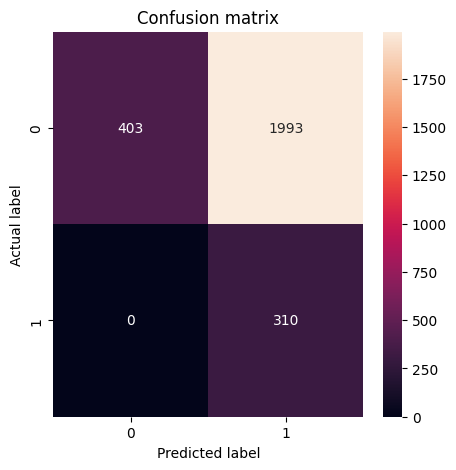

In [24]:
# test the model
model.eval()

total_loss = 0
all_labels = []
all_predictions = []

progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))

for i, batch in progress_bar:
    progress_bar.set_description('Testing')
    
    X_batch, y_batch = batch
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    
    with torch.no_grad():
        y_pred = model(X_batch).squeeze() 
    
    loss = criterion(y_pred, y_batch.float())
    
    y_pred = torch.sigmoid(y_pred)
    y_pred = torch.round(y_pred)
    
    all_labels.extend(y_batch.tolist())
    all_predictions.extend(y_pred.tolist())
    
    total_loss += loss.item()
    
    progress_bar.set_postfix({'testing_loss': total_loss / (i + 1)})

# Calculate and print metrics after the loop
total_accuracy = accuracy_score(all_labels, all_predictions)
total_f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

print(f'Testing Accuracy: {total_accuracy}')
print(f'Testing F1 Score: {total_f1_weighted}')
print(classification_report(all_labels, all_predictions))

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bidirectional=False, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Take the output from the last time step
        output = self.fc(lstm_out)
        return output

# Define hyperparameters for the LSTM model
lstm_hidden_size = 128
lstm_num_layers = 2
lstm_bidirectional = True
output_size = 1  # For binary classification, adjust if you have multiple classes

# Create an instance of the LSTM model
lstm_model = LSTMModel(embed_dim, lstm_hidden_size, output_size, num_layers=lstm_num_layers, bidirectional=lstm_bidirectional)
lstm_model = lstm_model.to(device)

# Define optimizer and loss function
lstm_optimizer = optim.AdamW(lstm_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lstm_criterion = nn.BCEWithLogitsLoss()

# Training loop for the LSTM model
for epoch in range(epochs):
    
    print('-' * 10)
    
    total_train_loss = 0
    total_train_accuracy = 0
    total_train_f1 = 0
    
    lstm_model.train()  # Use lstm_model instead of model

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    for i, batch in progress_bar:
        progress_bar.set_description(f'[Training] Epoch {epoch}]')
        
        lstm_optimizer.zero_grad()  # Use lstm_optimizer instead of optimizer
        
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred = lstm_model(X_batch).squeeze()  # Use lstm_model instead of model
        
        loss = lstm_criterion(y_pred, y_batch.float())  # Use lstm_criterion instead of criterion
        
        loss.backward()
        lstm_optimizer.step()
        
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)

        total_train_loss += loss.item()
        total_train_accuracy += accuracy_score(y_batch.tolist(), y_pred.detach().cpu().numpy().tolist())
        total_train_f1 += f1_score(y_batch.tolist(), y_pred.detach().cpu().numpy().tolist(), average='weighted')
        
        progress_bar.set_postfix({'training_loss': total_train_loss / (i + 1), 'training_accuracy': total_train_accuracy / (i + 1), 'training_f1': total_train_f1 / (i + 1)})


# Testing the LSTM model
lstm_model.eval()

lstm_total_loss = 0
lstm_all_labels = []
lstm_all_predictions = []

for i, batch in enumerate(test_loader):
    X_batch, y_batch = batch
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    with torch.no_grad():
        lstm_y_pred = lstm_model(X_batch).squeeze()

    lstm_loss = lstm_criterion(lstm_y_pred, y_batch.float())
    lstm_y_pred = torch.sigmoid(lstm_y_pred)
    lstm_y_pred = torch.round(lstm_y_pred)

    lstm_all_labels.extend(y_batch.tolist())
    lstm_all_predictions.extend(lstm_y_pred.tolist())
    lstm_total_loss += lstm_loss.item()

# Calculate and print metrics for the LSTM model
lstm_total_accuracy = accuracy_score(lstm_all_labels, lstm_all_predictions)
lstm_total_f1_weighted = f1_score(lstm_all_labels, lstm_all_predictions, average='weighted')

print(f'Testing Accuracy (LSTM Model): {lstm_total_accuracy}')
print(f'Testing F1 Score (LSTM Model): {lstm_total_f1_weighted}')
print(classification_report(lstm_all_labels, lstm_all_predictions))


----------


[Training] Epoch 0]: 100%|██████████| 23/23 [02:32<00:00,  6.63s/it, training_loss=0.636, training_accuracy=0.705, training_f1=0.668]


----------


[Training] Epoch 1]: 100%|██████████| 23/23 [02:29<00:00,  6.52s/it, training_loss=0.501, training_accuracy=0.736, training_f1=0.714]


----------


[Training] Epoch 2]: 100%|██████████| 23/23 [02:10<00:00,  5.68s/it, training_loss=0.521, training_accuracy=0.725, training_f1=0.696]


----------


[Training] Epoch 3]: 100%|██████████| 23/23 [01:56<00:00,  5.07s/it, training_loss=0.503, training_accuracy=0.727, training_f1=0.704]


----------


[Training] Epoch 4]: 100%|██████████| 23/23 [02:00<00:00,  5.25s/it, training_loss=0.502, training_accuracy=0.723, training_f1=0.709]


----------


[Training] Epoch 5]: 100%|██████████| 23/23 [02:06<00:00,  5.50s/it, training_loss=0.495, training_accuracy=0.743, training_f1=0.724]


----------


[Training] Epoch 6]: 100%|██████████| 23/23 [02:06<00:00,  5.50s/it, training_loss=0.527, training_accuracy=0.715, training_f1=0.683]


----------


[Training] Epoch 7]: 100%|██████████| 23/23 [01:46<00:00,  4.62s/it, training_loss=0.499, training_accuracy=0.737, training_f1=0.715]


----------


[Training] Epoch 8]: 100%|██████████| 23/23 [01:40<00:00,  4.36s/it, training_loss=0.519, training_accuracy=0.702, training_f1=0.661]


----------


[Training] Epoch 9]: 100%|██████████| 23/23 [01:31<00:00,  3.99s/it, training_loss=0.516, training_accuracy=0.701, training_f1=0.664]


----------


[Training] Epoch 10]: 100%|██████████| 23/23 [02:00<00:00,  5.22s/it, training_loss=0.491, training_accuracy=0.741, training_f1=0.72] 


----------


[Training] Epoch 11]: 100%|██████████| 23/23 [01:57<00:00,  5.12s/it, training_loss=0.447, training_accuracy=0.8, training_f1=0.793]  


----------


[Training] Epoch 12]: 100%|██████████| 23/23 [01:17<00:00,  3.37s/it, training_loss=0.479, training_accuracy=0.713, training_f1=0.68] 


----------


[Training] Epoch 13]: 100%|██████████| 23/23 [01:18<00:00,  3.43s/it, training_loss=0.417, training_accuracy=0.828, training_f1=0.824]


----------


[Training] Epoch 14]: 100%|██████████| 23/23 [01:08<00:00,  3.00s/it, training_loss=0.397, training_accuracy=0.828, training_f1=0.823]


----------


[Training] Epoch 15]: 100%|██████████| 23/23 [01:26<00:00,  3.77s/it, training_loss=0.403, training_accuracy=0.827, training_f1=0.825]


----------


[Training] Epoch 16]: 100%|██████████| 23/23 [01:11<00:00,  3.12s/it, training_loss=0.411, training_accuracy=0.825, training_f1=0.821]


----------


[Training] Epoch 17]: 100%|██████████| 23/23 [01:11<00:00,  3.11s/it, training_loss=0.408, training_accuracy=0.826, training_f1=0.822]


----------


[Training] Epoch 18]: 100%|██████████| 23/23 [01:10<00:00,  3.07s/it, training_loss=0.43, training_accuracy=0.822, training_f1=0.816] 


----------


[Training] Epoch 19]: 100%|██████████| 23/23 [01:09<00:00,  3.02s/it, training_loss=0.385, training_accuracy=0.827, training_f1=0.823]


----------


[Training] Epoch 20]: 100%|██████████| 23/23 [01:05<00:00,  2.87s/it, training_loss=0.338, training_accuracy=0.811, training_f1=0.81] 


----------


[Training] Epoch 21]: 100%|██████████| 23/23 [01:11<00:00,  3.11s/it, training_loss=0.316, training_accuracy=0.826, training_f1=0.824]


----------


[Training] Epoch 22]: 100%|██████████| 23/23 [01:07<00:00,  2.93s/it, training_loss=0.346, training_accuracy=0.816, training_f1=0.816]


----------


[Training] Epoch 23]: 100%|██████████| 23/23 [01:18<00:00,  3.43s/it, training_loss=0.348, training_accuracy=0.815, training_f1=0.811]


----------


[Training] Epoch 24]: 100%|██████████| 23/23 [01:23<00:00,  3.63s/it, training_loss=0.333, training_accuracy=0.818, training_f1=0.817]


Testing Accuracy (LSTM Model): 0.9408721359940873
Testing F1 Score (LSTM Model): 0.936514981612732
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2396
           1       0.84      0.60      0.70       310

    accuracy                           0.94      2706
   macro avg       0.89      0.79      0.83      2706
weighted avg       0.94      0.94      0.94      2706



  0%|          | 0/85 [00:00<?, ?it/s]

Testing: 100%|██████████| 85/85 [00:38<00:00,  2.21it/s, testing_loss=0.222]


Testing Accuracy: 0.9408721359940873
Testing F1 Score: 0.936514981612732
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2396
           1       0.84      0.60      0.70       310

    accuracy                           0.94      2706
   macro avg       0.89      0.79      0.83      2706
weighted avg       0.94      0.94      0.94      2706



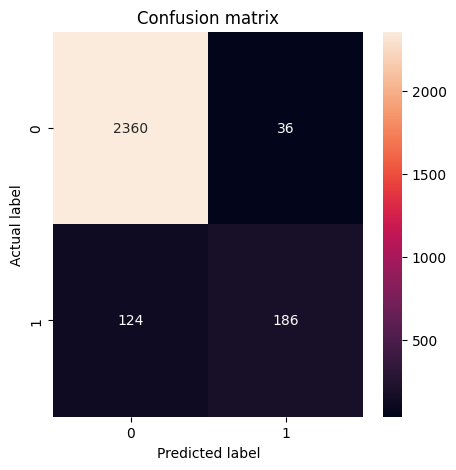

In [18]:
# test the model
lstm_model.eval()

total_loss = 0
all_labels = []
all_predictions = []

progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))

for i, batch in progress_bar:
    progress_bar.set_description('Testing')
    
    X_batch, y_batch = batch
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    
    with torch.no_grad():
        y_pred = lstm_model(X_batch).squeeze() 
    
    loss = criterion(y_pred, y_batch.float())
    
    y_pred = torch.sigmoid(y_pred)
    y_pred = torch.round(y_pred)
    
    all_labels.extend(y_batch.tolist())
    all_predictions.extend(y_pred.tolist())
    
    total_loss += loss.item()
    
    progress_bar.set_postfix({'testing_loss': total_loss / (i + 1)})

# Calculate and print metrics after the loop
total_accuracy = accuracy_score(all_labels, all_predictions)
total_f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

print(f'Testing Accuracy: {total_accuracy}')
print(f'Testing F1 Score: {total_f1_weighted}')
print(classification_report(all_labels, all_predictions))

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()